In [51]:
# standard python imports
import matplotlib.pyplot as plt
import numpy as np

# tidy3d imports
import tidy3d as td
import tidy3d.web as web
# from tidy3d import Material

# set plotting style
from plot.plot_style import set_plot_style
set_plot_style(colors=False, dpi=300)


## Define the structure and boundary conditions
Note the special treatment in creating the mesh: we need to make sure that the mesh is sufficiently fine within the sphere, but we can also make use of `Tidy3D`'s non-uniform meshing algorithm to have a coarser grid outside the sphere, for better efficiency. Furthermore, the TFSF source works best if placed in a region with uniform mesh. Because of this, we will add a mesh override structure which is slightly larger than the sphere itself.

In [52]:
# Deifne cube
length = 300e-3
center = [0, 0, 0]


# Cube geometry object
geometry = td.Box(center=center, 
                  size=(length, length, length))




## Si material definition

#  Define material
medium = td.Medium(permittivity=14.31)

# free space central wavelength of the pulse excitation
wavelength = 700e-3
f0 = td.C_0 / wavelength

# bandwidth in Hz
fwidth = f0 / 5.0
fmin = td.C_0 /650e-3
fmax = td.C_0 /750e-3
wavelength_max = td.C_0 / fmin
wavelength_min = td.C_0 / fmax

# distance between particle and the boundary of the tfsf box
buffer_tfsf = 0.3 * length
tfsf_size = (length + buffer_tfsf) * 2

# distance between the particle and the scattered field region monitors (should be larger than buffer_tfsf)
buffer_out = 0.4 * length
out_size = (length + buffer_out) * 2

# distance between the particle and the total field region monitor (should be smaller than buffer_tfsf)
buffer_in = 0.2 * length
in_size = (length + buffer_in) * 2

# distance between particle and the mesh override region
buffer_override = 0.8 * length
override_size = (length + buffer_override) * 2

# The nanoparticle is very electrically small in the frequency range considered here, and meshing
# based on a standard 10-30 points per wavelength would lead to a grid too coarse to resolve the
# curvature of the sphere. Instead, we just define how many cells we want within the sphere diameter
# by creating a mesh override region
cells_per_wavelength = 50  # for meshing outside of the particle
cells_in_particle = 60  # for the mesh override region
mesh_override = td.MeshOverrideStructure(
    geometry=td.Box(center=center, size=(override_size,) * 3),
    dl=(2 * length / cells_in_particle,) * 3,
)

# create the cube
cube = td.Structure(geometry=geometry, medium=medium)
geometry = [cube]

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_pml = wavelength_max / 2

# set the full simulation size along x, y, and z
sim_size = [(length + buffer_pml) * 2] * 3

# define PML layers on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

In [53]:
help(td.Medium())

Help on Medium in module tidy3d.components.medium object:

class Medium(AbstractMedium)
 |  Medium(*, name: str = None, frequency_range: Tuple[float, float] = None, allow_gain: bool = False, nonlinear_spec: Union[tidy3d.components.medium.NonlinearSpec, tidy3d.components.medium.NonlinearSusceptibility] = None, modulation_spec: tidy3d.components.time_modulation.ModulationSpec = None, heat_spec: Union[tidy3d.components.heat_spec.FluidSpec, tidy3d.components.heat_spec.SolidSpec, NoneType] = None, type: Literal['Medium'] = 'Medium', permittivity: pydantic.v1.types.ConstrainedFloatValue = 1.0, conductivity: float = 0.0) -> None
 |  
 |  Dispersionless medium.
 |  
 |  Parameters
 |  ----------
 |  name : Optional[str] = None
 |      Optional unique name for medium.
 |  frequency_range : Optional[Tuple[float, float]] = None
 |      [units = (Hz, Hz)].  Optional range of validity for the medium.
 |  allow_gain : bool = False
 |      Allow the medium to be active. Caution: simulations with a ga

In [54]:
# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

# the tfsf source is defined as a box around the particle
source = td.TFSF(
    center=center,
    size=(tfsf_size,) * 3,
    source_time=gaussian,
    injection_axis=2,  # inject along the z axis...
    direction="+",  # ...in the positive direction, i.e. along z+
    name="tfsf",
    pol_angle=0,
)

# Simulation run time
run_time = 10 / fwidth

## Create Monitors

Next, we define a number of monitors to analyze the simulation.

- A 3D FluxMonitor inside the TFSF source can be used to compute the power absorbed in the particle. If no power is absorbed, the recorded flux would be 0, since there are no power sources or sinks inside the monitor box. Any flux recorded in the FluxMonitor is then due to the imbalance between the incoming power and the outgoing one, which has been reduced by the particle absorption.

- A 3D FluxMonitor outside the TFSF region can be used to compute the total cross-section, meaning the total power of scattered radiation in all directions.

- A [FieldProjectionAngleMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjectionAngleMonitor.html) can be used to compute the radiated cross-section at a particular angle.

- Finally, we also store the fields in a planar cross-section for visualization purposes.

In [55]:
# set the list of frequencies at which to compute quantities
num_freqs = 100
freqs = np.linspace(fmin, fmax, 100)

monitor_flux_out = td.FluxMonitor(
    size=[out_size] * 3,
    freqs=freqs,
    name="flux_out",
)
monitor_flux_in = td.FluxMonitor(
    size=[in_size] * 3,
    freqs=freqs,
    name="flux_in",
)

# define a field time monitor to record time-domain animation frames
time_monitor = td.FieldTimeMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    fields=["Ez"],
    start=0,
    stop=run_time,
    interval=100,
    interval_space=(3, 3, 1),
    name="time_movie_monitor",
)


monitors = [monitor_flux_out, monitor_flux_in, time_monitor]

## Create Simulation

Now we can put everything together and define the simulation.

In [56]:
# since the mesh is extremely fine near the particle and transitions to a coarser mesh farther out,
# we can use the 'max_scale' field to set the largest allowed increase in mesh size from one cell to
# the next, to obtain a gentler gradient; the default is 1.4, and we'll set it to 1.2 here
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=cells_per_wavelength,
    override_structures=[mesh_override],
    max_scale=1.2,
)

sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
    shutoff=1e-8,
)

# inspect the temporal and sepectral of the source

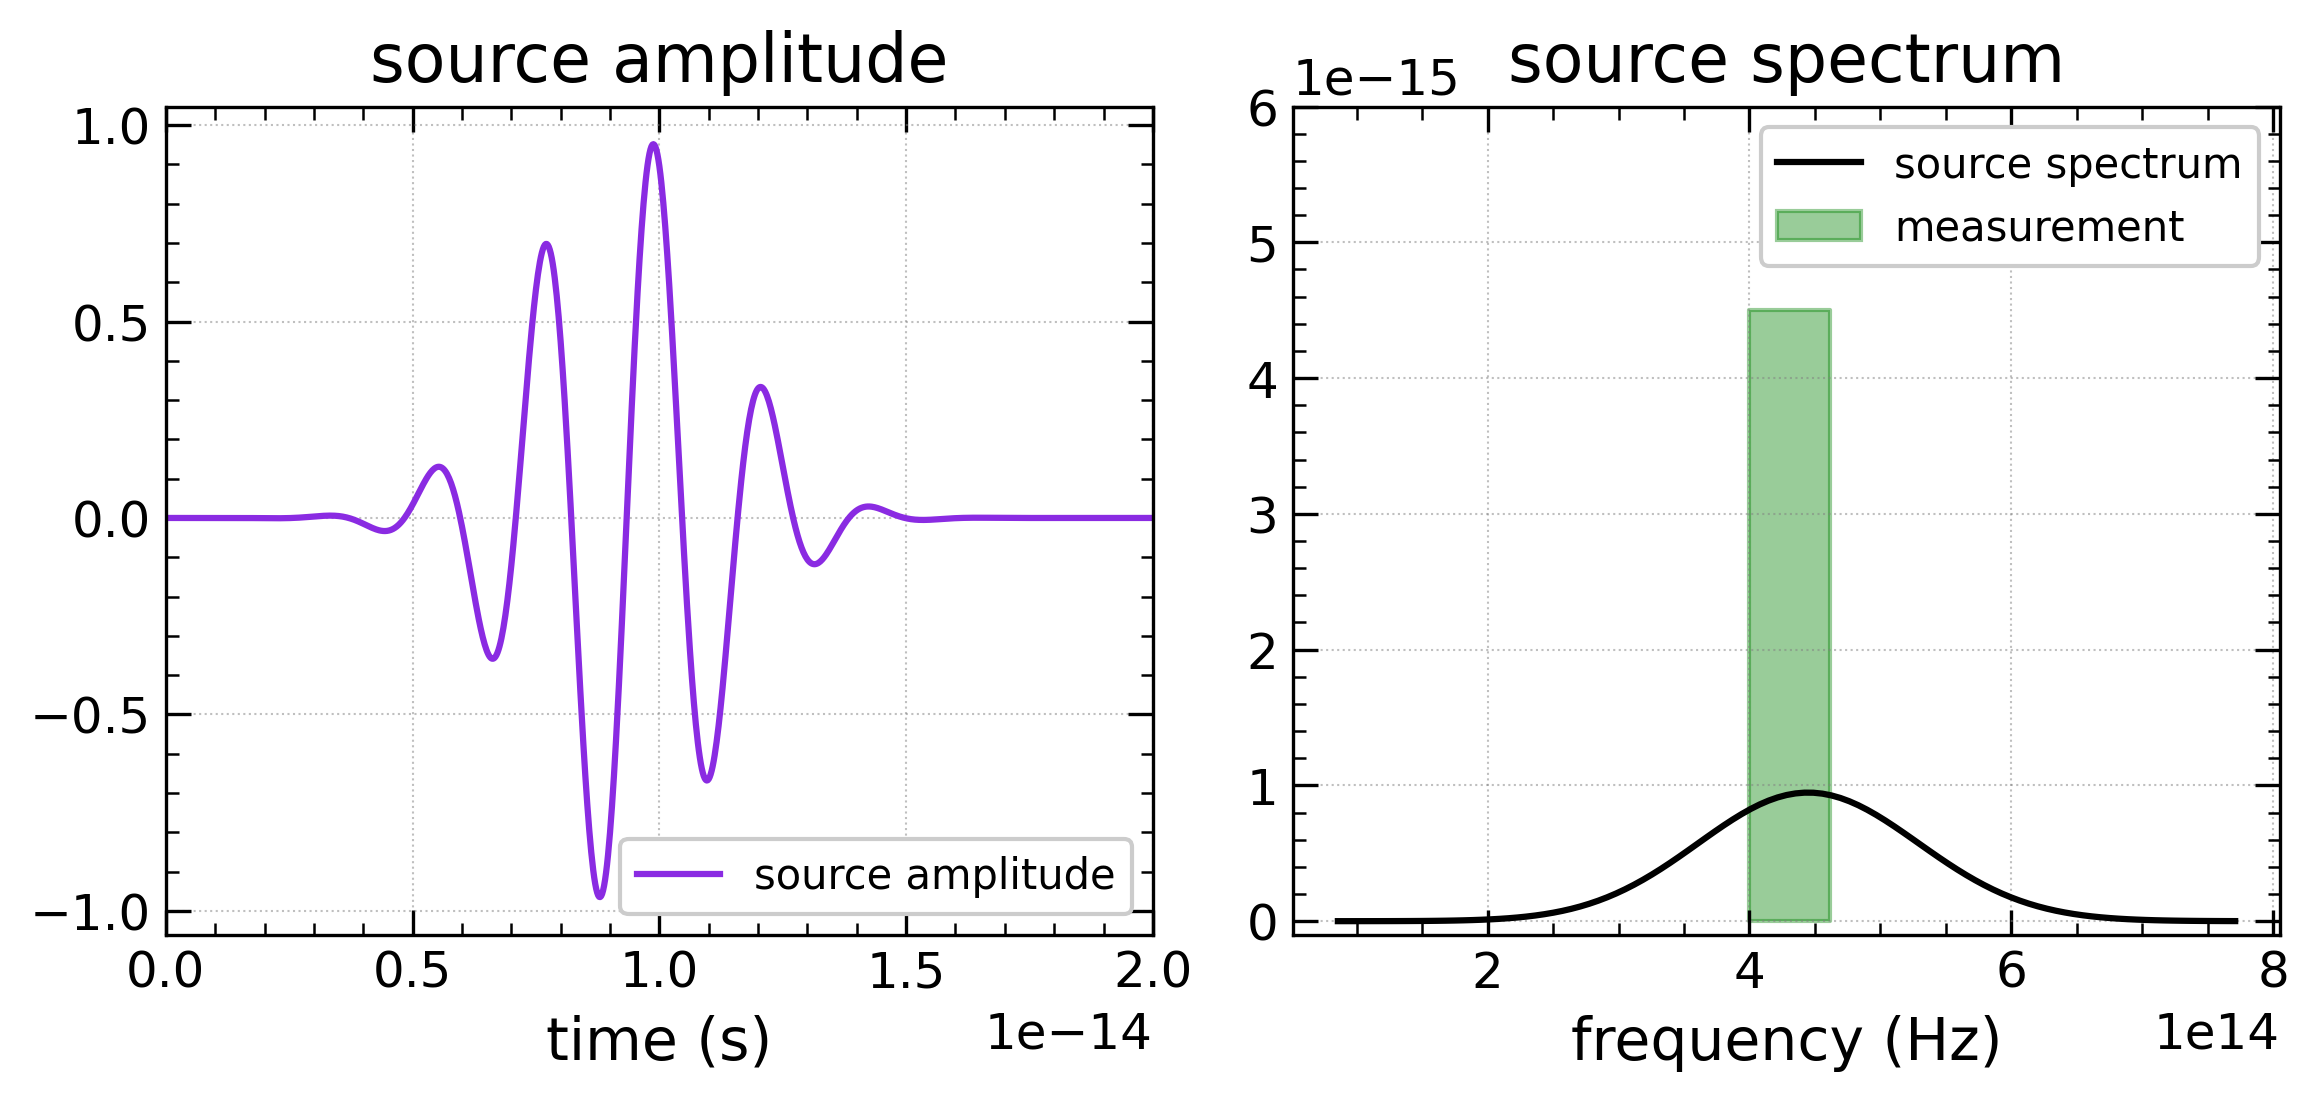

In [57]:
# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
plot_time = 0.02e-12
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, plot_time, 1001), ax=ax1)
ax1.set_xlim(0, plot_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 10001), val = 'abs', ax=ax2)
fill_max = 45e-16
ymax = 60e-16
ax2.fill_between((fmin, fmax), [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

# Inspect simulation parameters

In [58]:
# print(sim.grid_spec)
# print(sim.geometry)
# print(sim.sources)
# print(sim.monitors)


sim.plot_3d()




## Run Simulation

In [59]:
# Run simulation
sim_data = web.run(
    sim,
    task_name="cube_scattering",
    path="data/cube_scattering.hdf5",
    verbose=True,
)

07:26:23 CEST Created task 'cube_scattering' with task_id                       
              'fdve-e2da1c63-38a8-4fb1-90ee-8a58d3011327' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=425839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2da1c63-38a8-4fb1-90ee-8a58d3011327\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=155838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2da1c63-38a8-4fb1-90ee-8a58d3011327\taskId]8;;\]8;id=425839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2da1c63-38a8-4fb1-90ee-8a58d3011327\=]8;;\]8;id=419271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2da1c63-38a8-4fb1-90ee-8a58d3011327\fdve]8;;\]8;id=425839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2da1c63-38a8-4fb1-90ee-8a58d3011327\-e2da1c63-38]8;;\
              ]8;id=425839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2da1c63-38a8-4fb1-90ee-8a58d3011327\a8-4fb1-90ee-8a58d3011327']8;;\.

Output()

07:26:25 CEST status = success

Output()

07:26:29 CEST loading simulation from data/cube_scattering.hdf5

              WARNING: Simulation final field decay value of 0.00286 is greater 
              than the simulation shutoff threshold of 1e-08. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

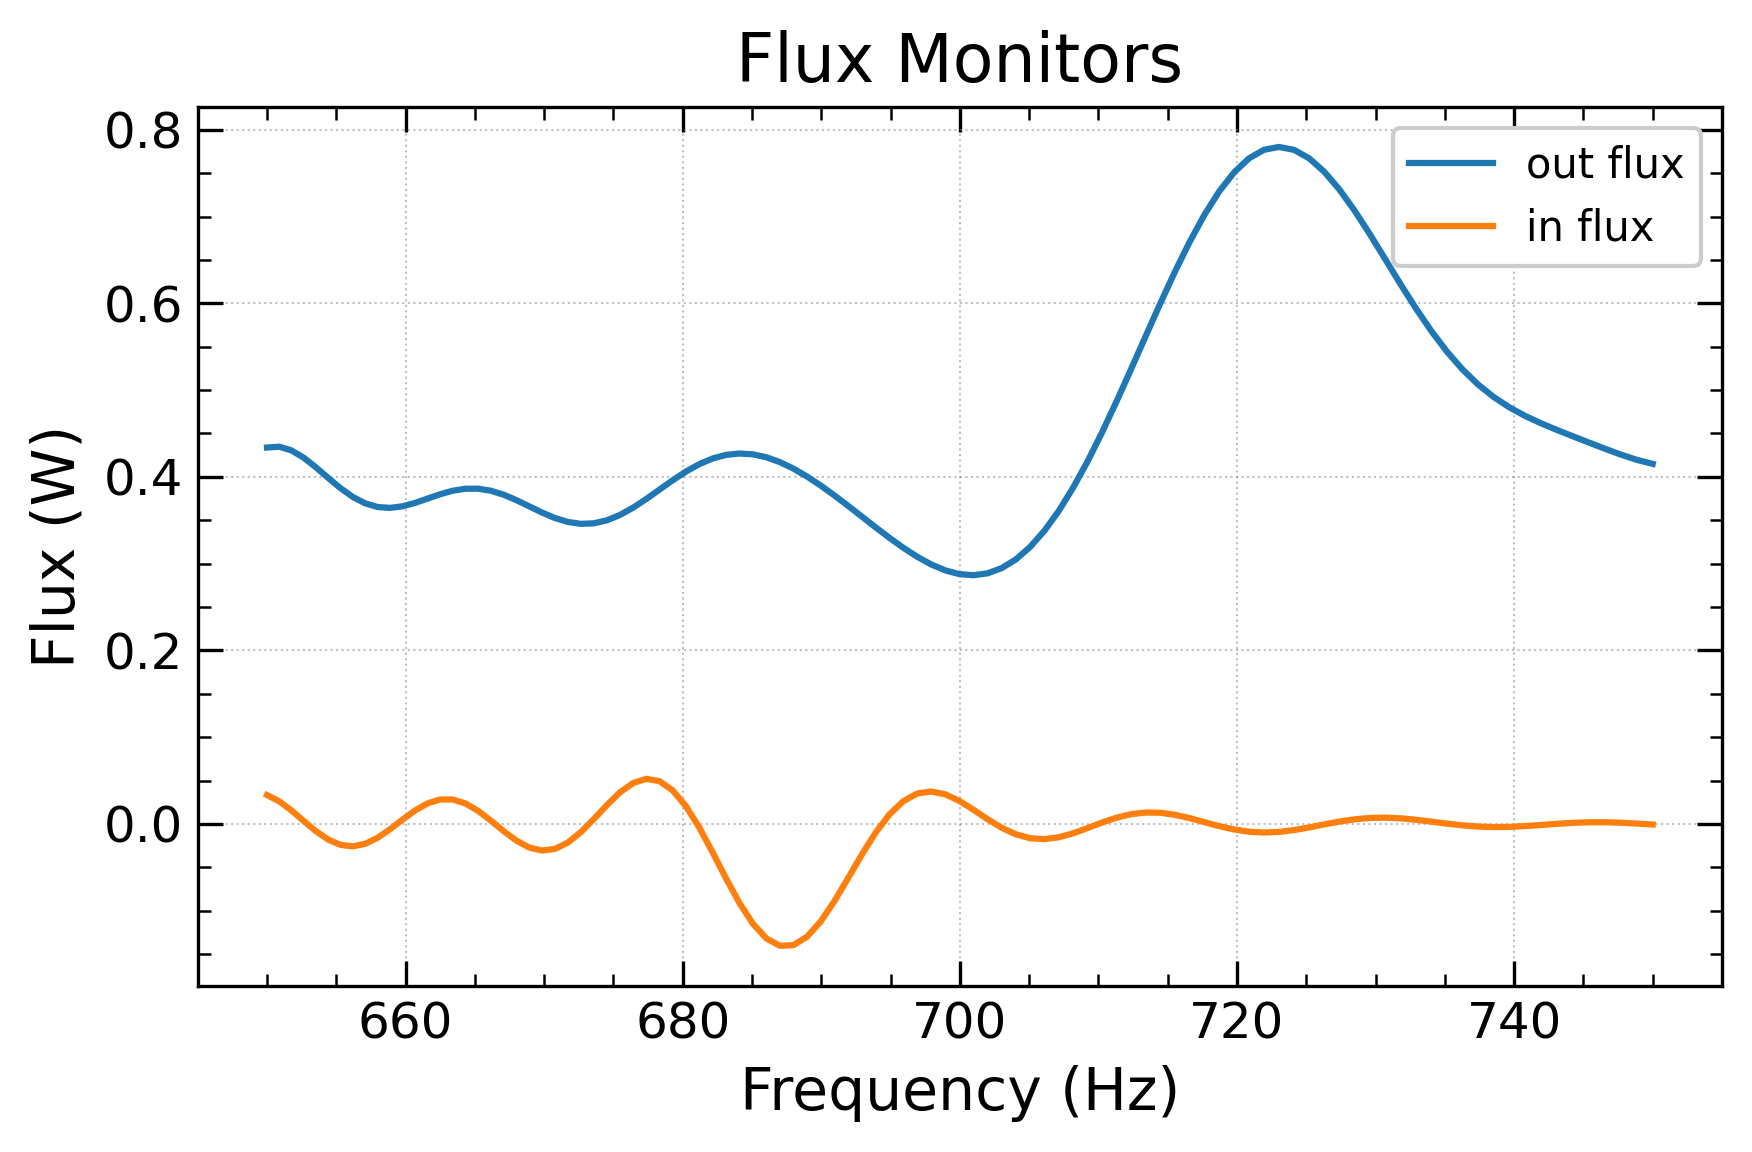

In [60]:
# Total scattered power
scattered_out = sim_data["flux_out"].flux
scattered_in = sim_data["flux_in"].flux

# plot flux monitors
f, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 4))
ax.plot(td.C_0 / freqs * 1e3, scattered_out, label="out flux")
ax.plot(td.C_0 / freqs * 1e3, scattered_in, label="in flux")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Flux (W)")

ax.legend()
ax.set_title("Flux Monitors")
plt.show()

## Efficiency calculation

In [61]:


# Eficiency = scattered_out / scattered_in

# # plot scattering efficiency
# fig, ax = plt.subplots(tight_layout=True, figsize=(6, 4))
# ax.plot(td.C_0 / freqs * 1e3, Eficiency, label="scattering efficiency")
# ax.set_xlabel("Frequency (Hz)")
# ax.set_ylabel("Scattering efficiency")
# ax.set_title("Scattering efficiency of a cube")
# ax.legend()

# ax.grid()
# plt.show()


# Crossection

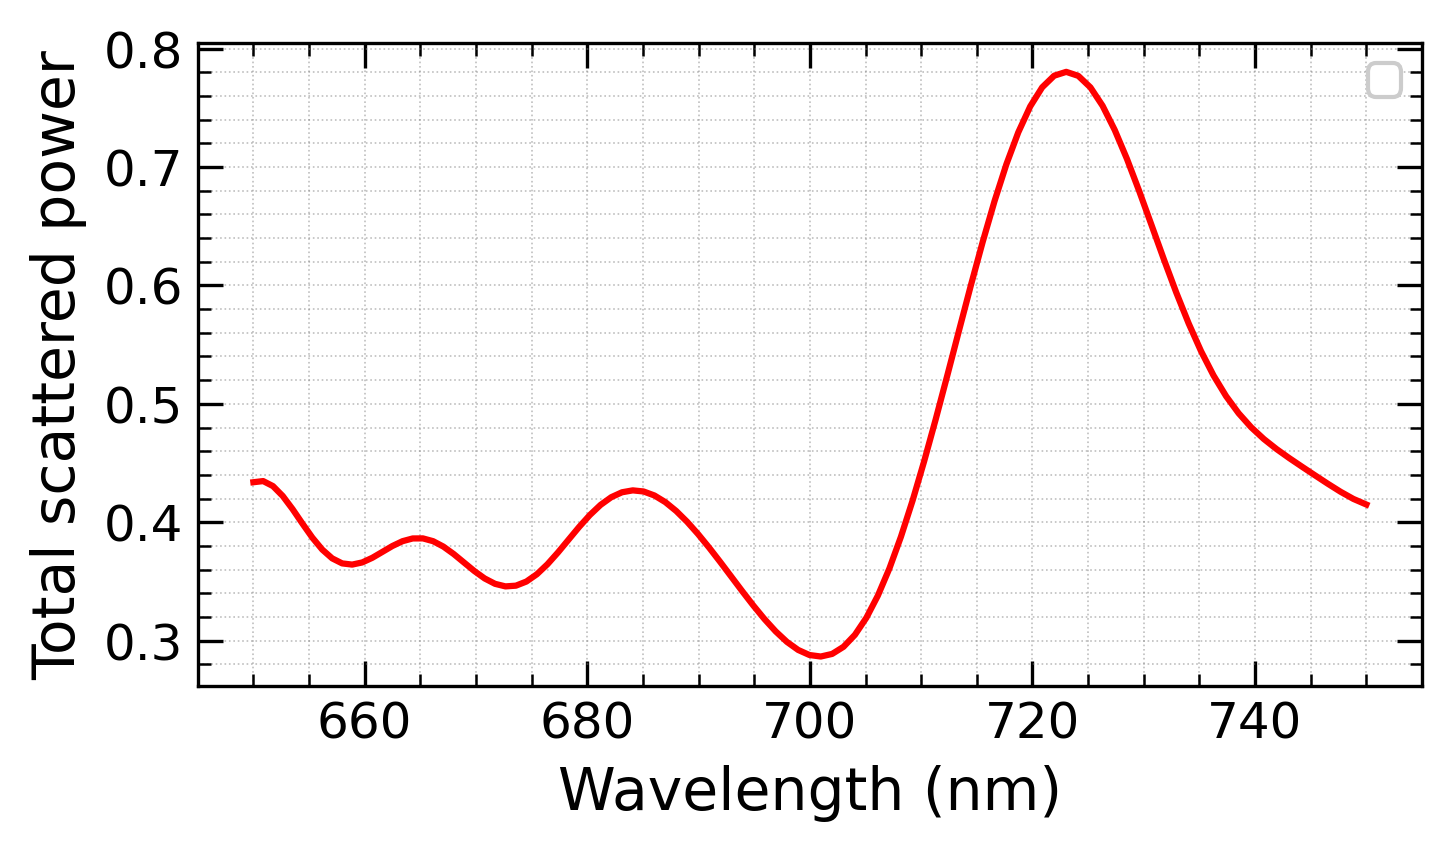

In [62]:


fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(td.C_0 / freqs * 1e3, scattered_out, "-r", )
ax.set(
    xlabel="Wavelength (nm)",
    ylabel="Total scattered power",
    yscale="linear",
    xscale="linear",
)
ax.legend()
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.tight_layout()
plt.show()

# Efficiency

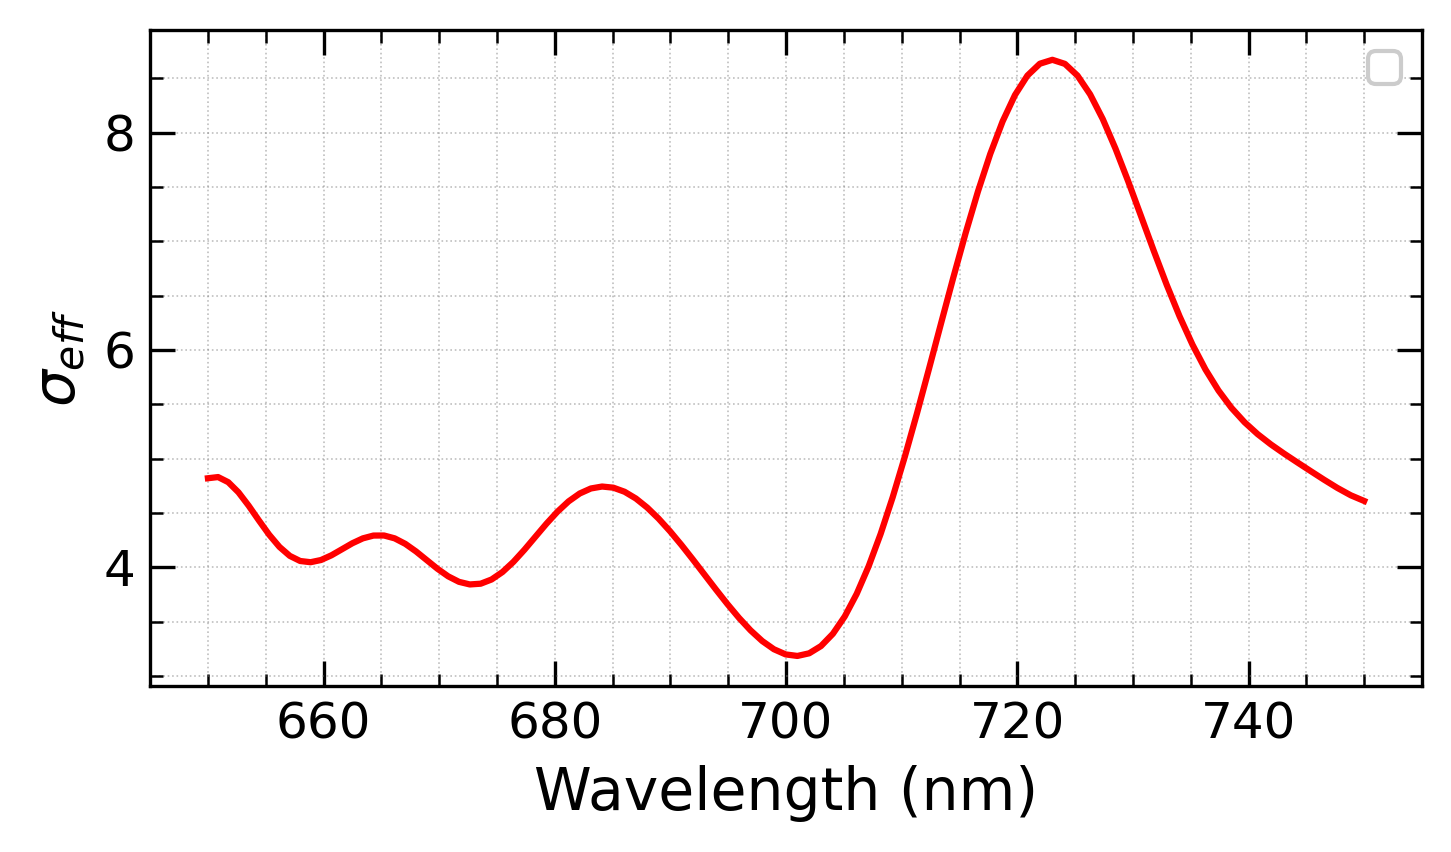

In [63]:
area = (length**2)
efficiency = scattered_out / (area )

# plot scattering efficiency

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(td.C_0 / freqs * 1e3, efficiency, "-r")
ax.set(
    xlabel="Wavelength (nm)",
    ylabel="$\sigma_{eff}$",
    yscale="linear",
    xscale="linear",
)
ax.legend()
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.tight_layout()
plt.show()

In [64]:
import matplotlib.animation as animation
from IPython.display import HTML

In [65]:
# t_end = sim_data["time_movie_monitor"].Ez.coords["t"][-1]  # end time of the animation
# frames = 50  # number of frames

# fig, ax = plt.subplots()


# def animate(i):
#     t = t_end * i / frames  # time at each frame
#     sim_data["time_movie_monitor"].Ez.sel(t=t, method="nearest").plot(
#         x="x", y="y", ax=ax, vmin=-0.1, vmax=0.1, add_colorbar=False, cmap="seismic"
#     )


# # create animation
# ani = animation.FuncAnimation(fig, animate, frames=frames)
# plt.close()

# # display the animation
# HTML(ani.to_jshtml())